## Классификация изображений цифр (датасет MNIST)

__Набор данных MNIST: примеры рукописных цифр__

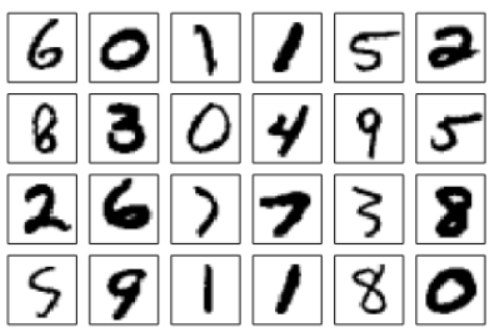

__MNIST__ - один из самых известных небольших наборов данных для распознавания простых изображений.
* MNIST состоит из рукописных цифр, изображенных на американский манер.
* Всего в MNIST содержится 70 000 размеченных черно-белых изображений размером 28 × 28 пикселов;

### Решение на torch

In [ ]:
import torch
import torchvision
import torchvision.datasets as datasets

# построение сети:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# рисование:
import matplotlib.pyplot as plt

In [ ]:
# Параметры модели:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

In [ ]:
# Обеспечиваем детерминированность результата:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
ls

sample_data/


In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root="./data/", train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root="./data/", train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.34MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.93MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Рассмотрим что представляют из себя данные:

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

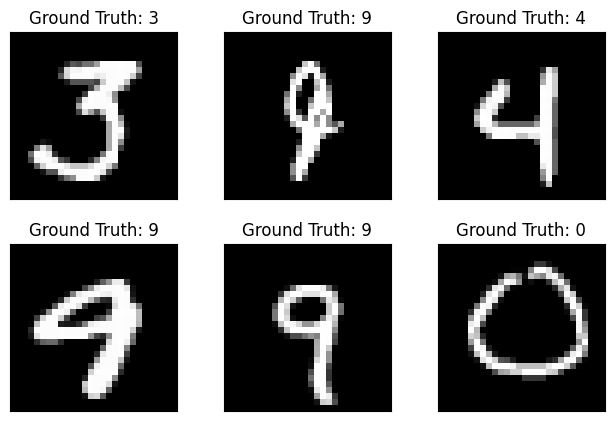

In [ ]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
# fig

In [ ]:
ex1 = example_data
print('ex1:', ex1.shape)

conv1 = nn.Conv2d(1, 10, kernel_size=5)
ex2 = conv1(ex1)
print('ex2:', ex2.shape)
ex3 = F.max_pool2d(ex2, 2)
print('ex3:', ex3.shape)

conv2 = nn.Conv2d(10, 20, kernel_size=5)
ex4 = conv2(ex3)
print('ex4:', ex4.shape)
ex5 = F.max_pool2d(ex4, 2)
print('ex5:', ex5.shape)

ex1: torch.Size([1000, 1, 28, 28])
ex2: torch.Size([1000, 10, 24, 24])
ex3: torch.Size([1000, 10, 12, 12])
ex4: torch.Size([1000, 20, 8, 8])
ex5: torch.Size([1000, 20, 4, 4])


In [ ]:
# класс нейронной сети:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() # p=0.5
        self.fc1 = nn.Linear(20*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # первый сверточный слой
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # второй сверточный слой
        x = x.view(-1, 20*4*4) # в двухмерный тензор с shape: (batch, 20*4*4)
        x = F.relu(self.fc1(x)) # первый полносвязный слой
        x = F.dropout(x, training=self.training)
        x = self.fc2(x) # второй полносвязный слой
        return F.log_softmax(x)

    def forward_1l(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # первый сверточный слой
        return x

In [ ]:
# создаем сеть:
network = Net()

# создаем оптимизатор:
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
    network.train() # has any effect only on certain modules e.g. Dropout, BatchNorm, etc.
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        # negative log likelihood loss. It is useful to train a classification problem with C classe:
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')

In [ ]:
def test(debug=False):
    network.eval() # equivalent with self.train(False)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
#             test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

#             pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
#             correct += pred.eq(target.data.view_as(pred)).sum()
            if debug:
                return output
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
# network.train()
# network.eval()

# F.nll_loss(output, target, size_average=False).item()
# # size_average

In [ ]:
o1 = test(debug=True)
o1

<ipython-input-10-2951371172e5>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([[-2.1867, -2.4826, -2.3482,  ..., -2.5043, -2.4274, -2.2389],
        [-2.3169, -2.4724, -2.3080,  ..., -2.5145, -2.3477, -2.3211],
        [-2.4042, -2.4217, -2.1948,  ..., -2.3982, -2.2912, -2.3842],
        ...,
        [-2.4162, -2.4415, -2.2334,  ..., -2.5106, -2.3318, -2.3415],
        [-2.2683, -2.4052, -2.3197,  ..., -2.4329, -2.3992, -2.3241],
        [-2.2155, -2.5386, -2.3341,  ..., -2.4908, -2.3521, -2.3449]])

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

<ipython-input-10-2951371172e5>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3122, Accuracy: 1212/10000 (12%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.353529
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.272738
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.254060
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.261289
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.266305
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.266457
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.168791
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.076318
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.092781
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.932947
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.753155
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.637165
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.532489
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.365008
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.594908
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.368472
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.249937
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.201526
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.295795
Train Epoch: 1 [12160

Text(0, 0.5, 'negative log likelihood loss')

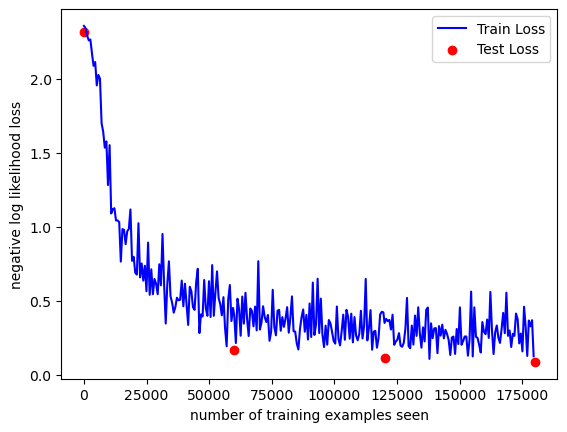

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
# fig

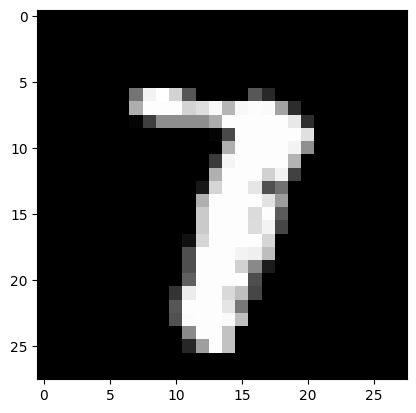

In [ ]:
img_n = 42
plt.imshow(example_data[42,0], cmap='gray')
plt.show()

===

In [ ]:
example_data[42,0]

tensor([[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242

In [ ]:
data1, target1 = next(iter(test_loader))
print(data1.shape, target1.shape)

img_n = 42
img_row = 5
img_col = 6
img_qty = img_row * img_col

data1_part = data1[img_n:img_n+img_qty, :, :, :]
target1_part = target1[img_n:img_n+img_qty]
print(data1_part.shape, target1_part.shape)

output = network(data1_part)
# test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
# +=
print(pred.shape, pred[5].item())
correct = pred.eq(target1_part.view_as(pred)).sum().item()
print(correct)

torch.Size([1000, 1, 28, 28]) torch.Size([1000])
torch.Size([30, 1, 28, 28]) torch.Size([30])
torch.Size([30, 1]) 7
29


<ipython-input-10-2951371172e5>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


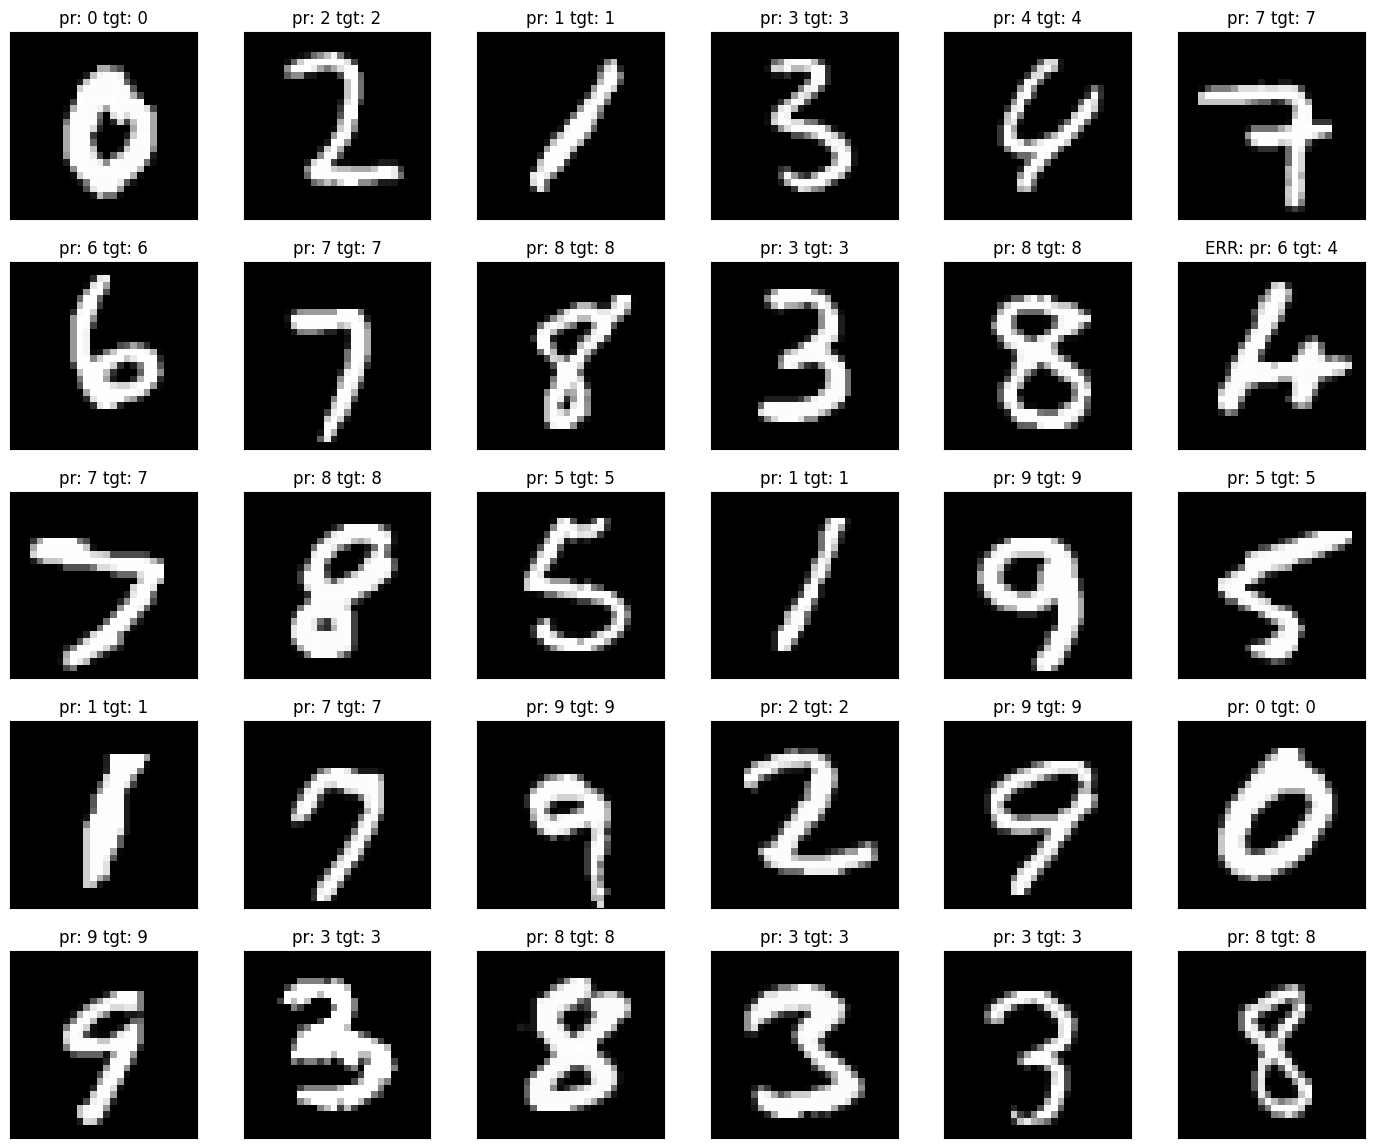

In [ ]:
fig = plt.figure(figsize=(14,12))

for i in range(img_qty):
    plt.subplot(img_row, img_col, i+1)
    plt.tight_layout()
    plt.imshow(data1_part[i][0], cmap='gray', interpolation='none')
    if pred[i].item() == target1_part[i]:
        plt.title(f"pr: {pred[i].item()} tgt: {target1_part[i]}")
    else:
        plt.title(f"ERR: pr: {pred[i].item()} tgt: {target1_part[i]}")
    plt.xticks([])
    plt.yticks([])

----

#### Визуализация промежуточных активаций

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
#import datasets in torchvision
import torchvision.datasets as datasets

#import model zoo in torchvision
import torchvision.models as models
import torchvision.transforms as transforms

In [ ]:
print(network)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
# получение слоев модели:
list(network.children())

[Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1)),
 Dropout2d(p=0.5, inplace=False),
 Linear(in_features=320, out_features=50, bias=True),
 Linear(in_features=50, out_features=10, bias=True)]

In [ ]:
# рекурсивное получение всех слоев модели с учетом возможной вложенности
# (например, через группировку nn.Sequence):

def get_children(model: torch.nn.Module):
    # get children form model!
    children = list(model.children())
    flatt_children = []
    if children == []:
        # if model has no children; model is last child! :O
        return model
    else:
       # look for children from children... to the last child!
       for child in children:
            try:
                flatt_children.extend(get_children(child))
            except TypeError:
                flatt_children.append(get_children(child))
    return flatt_children

In [ ]:
network_children = get_children(network)
print(network_children)

[Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1)), Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1)), Dropout2d(p=0.5, inplace=False), Linear(in_features=320, out_features=50, bias=True), Linear(in_features=50, out_features=10, bias=True)]


In [ ]:
# получение тензора весов слоя:
tl = network_children[0].weight.data
print(type(tl), tl.shape)

<class 'torch.Tensor'> torch.Size([10, 1, 5, 5])


In [ ]:
def plot_filters_single_channel(t):

    #kernels depth * number of kernels
    print(f't.shape[0]: {t.shape[0]}; t.shape[1]: {t.shape[0]}')
    nplots = t.shape[0]*t.shape[1]
    ncols = 12

    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)

    count = 0
    fig = plt.figure(figsize=(ncols, nrows))

    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg,  cmap='Greys')
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_weights(model_children, layer_num):
    layer = model_children[layer_num]
    if isinstance(layer, nn.Conv2d):
        weight_tensor = layer.weight.data

        plot_filters_single_channel(weight_tensor)
        pass
    else:
        print("Can only visualize layers which are convolutional")

t.shape[0]: 10; t.shape[1]: 10


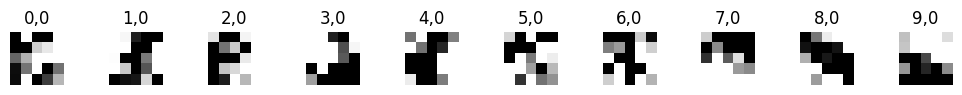

In [ ]:
plot_weights(network_children, 0)

torch.Size([30, 1, 28, 28])


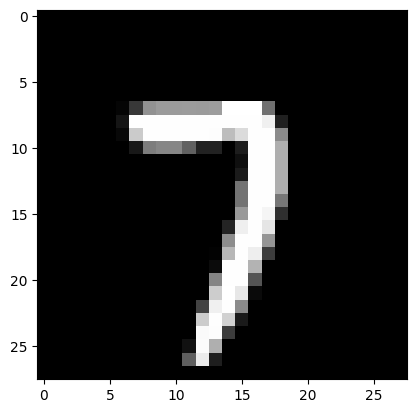

In [ ]:
print(data1_part.shape)

img_n = 7

plt.imshow(data1_part[img_n][0], cmap='gray')
plt.show()

torch.Size([30, 10, 12, 12])


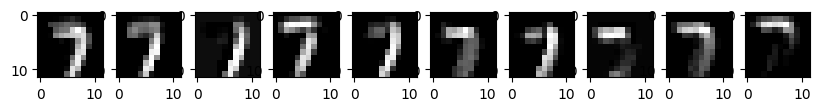

In [ ]:
with torch.no_grad():
    data1_part_1l = network.forward_1l(data1_part)

    print(data1_part_1l.shape)
    nplots = data1_part_1l.shape[1]
    ncols = 12

    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
#     npimg = np.array(t.numpy(), np.float32)

    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    #--------

    for i in range(data1_part_1l.shape[1]):
        count += 1
        ax1 = fig.add_subplot(nrows, ncols, count)

        ax1.imshow(data1_part_1l[img_n][i], cmap='gray')
    fig.show()

t.shape[0]: 20; t.shape[1]: 20


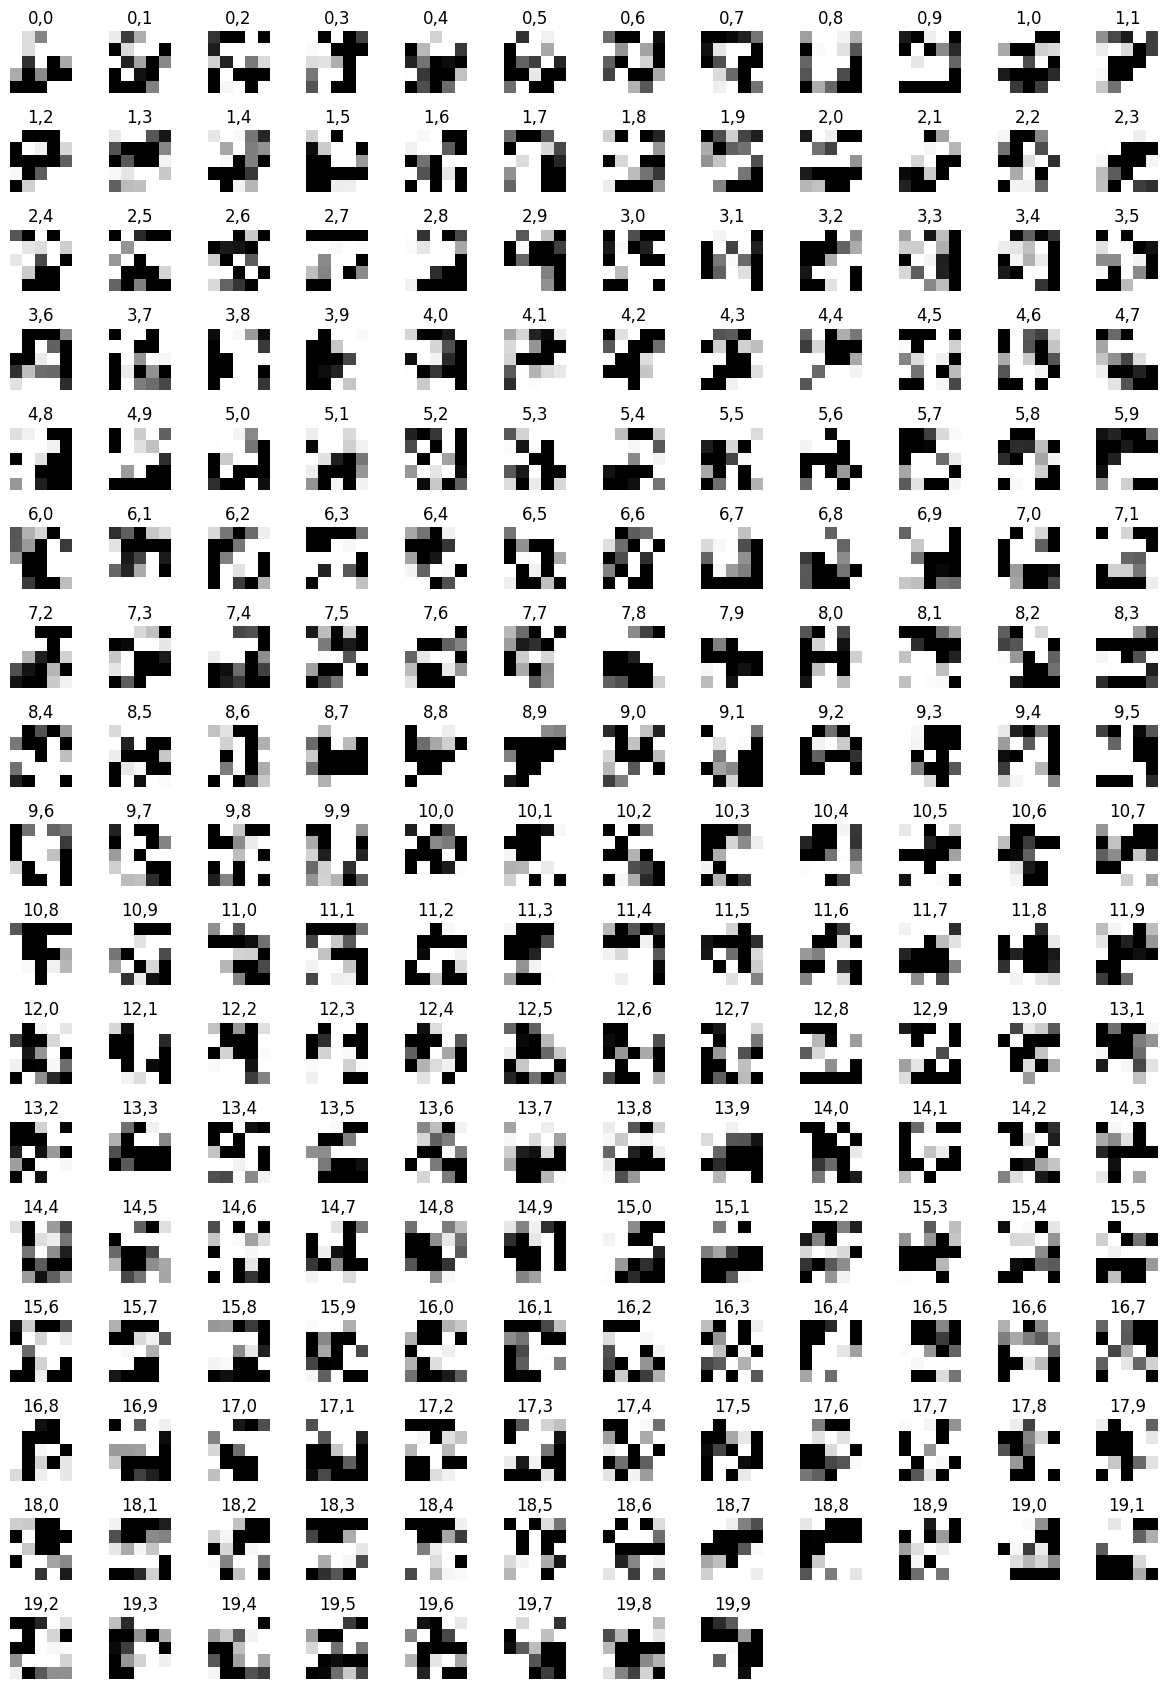

In [ ]:
plot_weights(network_children, 1)

### Решение на keras

In [ ]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
# загружаем данные MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
# превращаем каждую картинку в двумерный массив
batch_size, img_rows, img_cols = 64, 28, 28
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [ ]:
# приводим данные к типу float32 и нормализуем их от 0 до 1
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

In [ ]:
# переводим правильные ответы в one-hot представление
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [ ]:
# инициализируем модель
model = Sequential()

# добавляем сверточные слои
model.add(Convolution2D(32, 5, 5, border_mode="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="same"))
model.add(Convolution2D(64, 5, 5, border_mode="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="same"))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), input_shape=(28, 28, 1..., padding="same")`
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")`
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(28, 28, 1..., padding="same")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")`
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# добавляем полносвязные слои
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
# компилируем и запускаем обучение
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=10, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)

# выводим результаты
print("Test score: %f" % score[0])
print("Test accuracy: %f" % score[1])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


C:\ProgramData\Anaconda3\lib\site-packages\keras-2.0.2-py3.6.egg\keras\models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 26s - loss: 0.1243 - acc: 0.9619 - val_loss: 0.0376 - val_acc: 0.9877
Epoch 2/10
60000/60000 [==============================] - 14s - loss: 0.0420 - acc: 0.9870 - val_loss: 0.0298 - val_acc: 0.9909
Epoch 3/10
60000/60000 [==============================] - 14s - loss: 0.0302 - acc: 0.9902 - val_loss: 0.0251 - val_acc: 0.9915
Epoch 4/10
60000/60000 [==============================] - 13s - loss: 0.0224 - acc: 0.9931 - val_loss: 0.0218 - val_acc: 0.9928
Epoch 5/10
60000/60000 [==============================] - 14s - loss: 0.0185 - acc: 0.9941 - val_loss: 0.0253 - val_acc: 0.9926
Epoch 6/10
60000/60000 [==============================] - 13s - loss: 0.0158 - acc: 0.9953 - val_loss: 0.0251 - val_acc: 0.9922
Epoch 7/10
60000/60000 [==============================] - 14s - loss: 0.0138 - acc: 0.9957 - val_loss: 0.0248 - val_acc: 0.9933
Epoch 8/10
60000/60000 [==============================

---

In [ ]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras import models

(28, 28, 1) (28, 28)


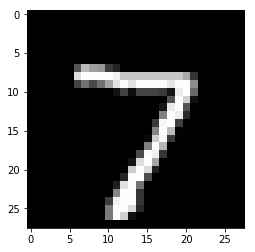

In [ ]:
viz_fig = X_test[0]
pixels = viz_fig.reshape((28, 28))
print(viz_fig.shape, pixels.shape)
plt.imshow(pixels, cmap='gray')
plt.show()

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
__________

In [ ]:
# Extracts the outputs of the top 4 layers:
layer_outputs = [layer.output for layer in model.layers[:4]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
viz_fig_v = viz_fig.copy()
viz_fig_v = np.expand_dims(viz_fig_v, axis=0)
viz_fig_v = viz_fig_v.astype("float32")
viz_fig_v /= 255

viz_fig_v.shape, input_shape

((1, 28, 28, 1), (28, 28, 1))

In [ ]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(viz_fig_v)

Помсмотрим на работу 1 слоя активации:

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 28, 28, 32)


Вывод получился очень большим, поэтому вставлю скрин:

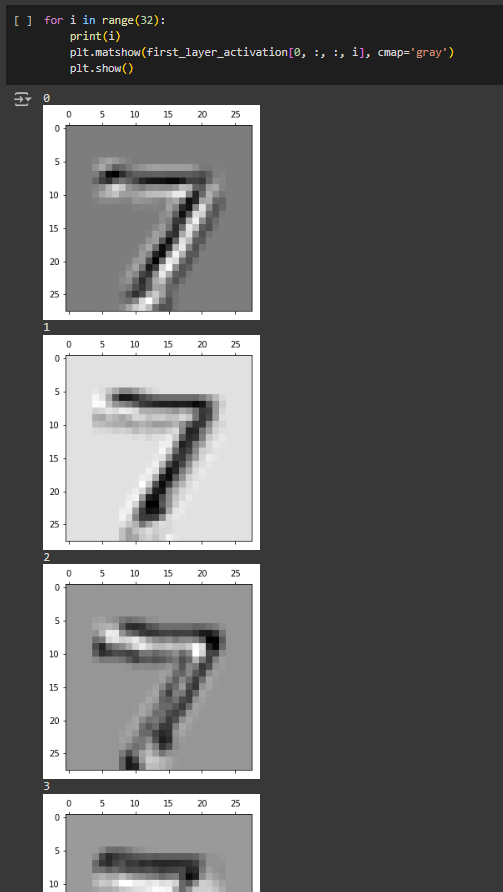

Аналогично, только с 4 слоем:

In [ ]:
second_layer_activation = activations[3]
print(second_layer_activation.shape)

(1, 14, 14, 64)


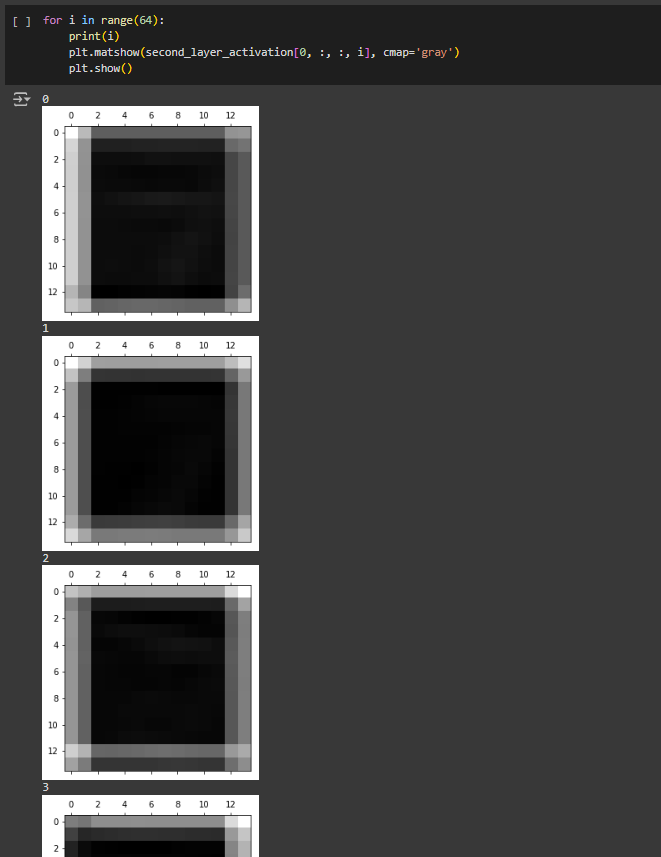